# AdaBoost

> [With AdaBoost], base classfiers are trained in sequence, and each base classifier is trained using a weighted form of the data set in which the weighting coefficient associated with each data point depends on the performance of the previous classifiers

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.metrics import confusion_matrix

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

Let $\mathcal D = \big\{({\bf x}_n, t_n) \vert {\bf x}_n \in \mathbb{R}^D, t_n \in \{-1, 1\}\big\}_{n=1}^N$ a training dataset. AdaBoost defines an estimation function $G$ defined as

$$
    G({\bf x}) = \text{sign}\left(\sum_{m=1}^M \alpha_m \cdot G_m({\bf x})\right)
$$

* $\alpha_m$ is the weighting coefficient over $G_m$
* $G_m$ is known as the weak learner

#### AdaBoost M.1 Algorithm

1. Initialize $\forall n: w_n = 1/N$
2. For $m=1,\ldots, M$:
    1. Train $G_m$ using the weighting coefficients $\{w_n^{(m)}\}_{n=1}^N$
    2. Compute 
       $$
         \text{err}_m = \frac{\sum_{n=1}^N w_n^{(m)}\mathbb{1}\big(t_n \neq G_m({\bf x}_n)\big)}{\sum_{n=1}^N w^{(m)}_n}
       $$
    3. Compute 
        $$
            \alpha_m = \log\left(\frac{1 - \text{err}_m}{\text{err}_m}\right)
        $$
    4. Define 
        $$
        \forall n: w_n^{(m + 1)} = w_{n}^{(m)} \exp\left(\alpha_m \cdot \mathbb{1}\big(t_n \neq G_m({\bf x}_n\big)\right)
        $$
       
Once we've iterated AdaBoost for $M$ iterations, we proceed to make a prediction using
$$
    G({\bf x}) = \text{sign}\left(\sum_{m=1}^M \alpha_m G_m({\bf x})\right)
$$


----

We can train $G_m$ using the following cost function:
$$
    J_m = \sum_{n=1}^N w_n^{(m)}\mathbb{1}\big(t_n \neq G_m({\bf x}_n)\big)
$$

* From 2.D, we see that in subsequent iterations the weighting coefficients $w_n^{(m)}$ are increased for datapoints that are **misclassified**.
* Hence, at every step, AdaBoost places greater attention to data points that were misclassied on the previous iteration by increasing their weight.

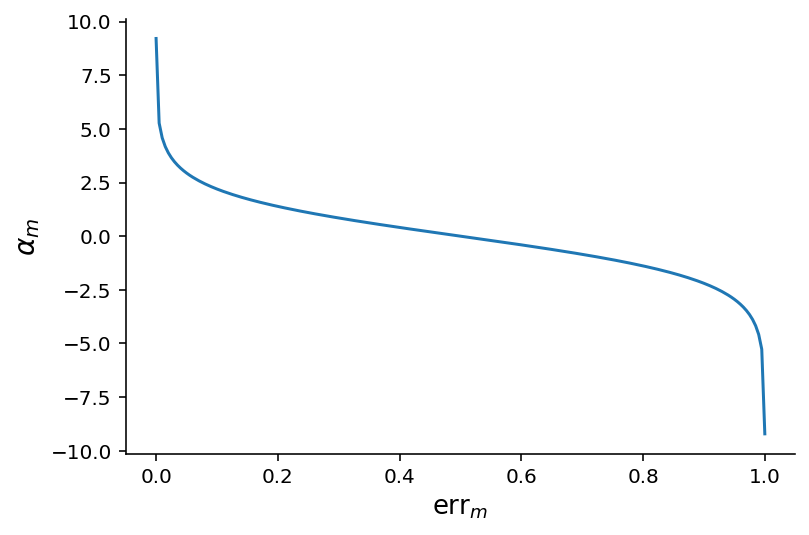

In [3]:
err_vals = np.linspace(1e-4, 1 - 1e-4, 200)
alpha_vals = np.log((1 - err_vals) / err_vals)
plt.plot(err_vals, alpha_vals)
plt.xlabel(r"err$_m$", fontsize=13);
plt.ylabel(r"$\alpha_m$", fontsize=14);

From the graph above we can see that weighting coefficients $\alpha_m$ give greater weight to the more accurate classifiers when computing $G$

## A practical example

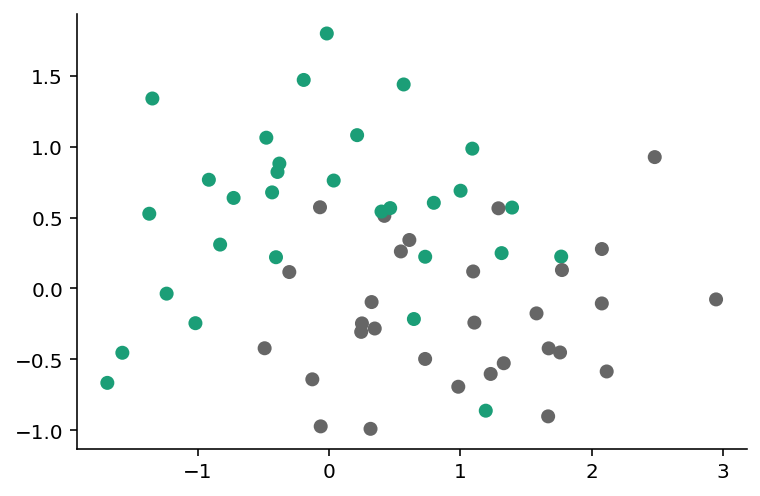

In [4]:
X, y = make_moons(n_samples=60, noise=0.4, random_state=3141)
y = 2 * y - 1
plt.scatter(*X.T, c=y, cmap="Dark2")

In [5]:
y

array([ 1,  1, -1, -1,  1, -1,  1, -1, -1,  1,  1,  1, -1,  1, -1,  1,  1,
       -1, -1,  1,  1, -1, -1, -1,  1,  1, -1,  1, -1, -1, -1,  1,  1, -1,
        1,  1, -1, -1,  1, -1,  1, -1,  1, -1,  1,  1, -1,  1, -1,  1, -1,
        1,  1,  1, -1, -1, -1, -1, -1,  1])

### Defining a single-split tree
(`see notebook on CART algorithm`)


We can train $G_m$ using the following cost function:
$$
    J_m = \sum_{n=1}^N w_n^{(m)}\mathbb{1}\big(t_n \neq G_m({\bf x}_n)\big)
$$

In [6]:
def Ri(X, j, s):
    return X[:, j] <= s

def find_partition(j, X, y, w, nrange=100):
    vmin, vmax = X[:,j].min(), X[:,j].max() * 0.99
    srange = np.linspace(vmin, vmax, nrange)
    yhat = Ri(X[..., None], j, srange)
    yhat = 2 * yhat - 1
    # Errors for each of the datapoints
    errs = yhat != y[:, None]
    # AdaBoost cost function
    Js = (errs * w[:, None]).sum(axis=0)
    # cutoff point
    s_cut = srange[Js.argmin()]
    return s_cut, Js.min(), errs[:, Js.argmin()]

def find_tree(X, y, w):
    partitions = [find_partition(j, X, -y * (-1) ** j, w) for j in [0, 1]]

    errs = [element[-1] for element in partitions]
    partitions = np.c_[[element[:-1] for element in partitions]]

    j_cut = partitions[:, -1].argmin()
    s_cut, J = partitions[j_cut]
    return j_cut, s_cut, J, errs[j_cut]

In [7]:
## AdaBoost for-loop
M = 150
w = np.ones_like(y) / len(y)
alpha_boost = []
index_boost = []
cutoff_boost = []
weights_hist = []

for m in range(M):
    j_cut, s_cut, J, errs = find_tree(X, y, w)
    err_m = (errs * w).sum() / w.sum()
    alpha_m = np.log((1 - err_m) / err_m)
    w = w * np.exp(alpha_m * errs)
    
    alpha_boost.append(alpha_m)
    index_boost.append(j_cut)
    cutoff_boost.append(s_cut)
    weights_hist.append(w)

In [8]:
def predict(X, j, s):
    yhat = Ri(X, j, s)
    yhat = 2 * yhat - 1
    # coding correction
    return -yhat * (-1) ** j

def adaboost_predict(X, alphas, indices, cutoffs):
    yhat = 0
    for alpha, index, s in zip(alphas, indices, cutoffs):
        yhat += alpha * predict(X, index, s)
    return np.sign(yhat).astype(int)

In [9]:
yhat = adaboost_predict(X, alpha_boost, index_boost, cutoff_boost)

In [10]:
confusion_matrix(y, yhat, labels=[-1, 1])

array([[27,  3],
       [ 5, 25]])

In [11]:
step = 0.01
Xgrid = np.mgrid[X[:, 0].min() * (1 + 0.1): X[:, 0].max() *  (1 + 0.1): step,
                 X[:, 1].min() * (1 + 0.1): X[:, 1].max() * (1 + 0.1): step]
_, M1, M2 = Xgrid.shape

In [12]:
yhat_grid = adaboost_predict(Xgrid.T.reshape(-1, 2), alpha_boost, index_boost, cutoff_boost)
yhat_grid = yhat_grid.reshape(M2, M1).T

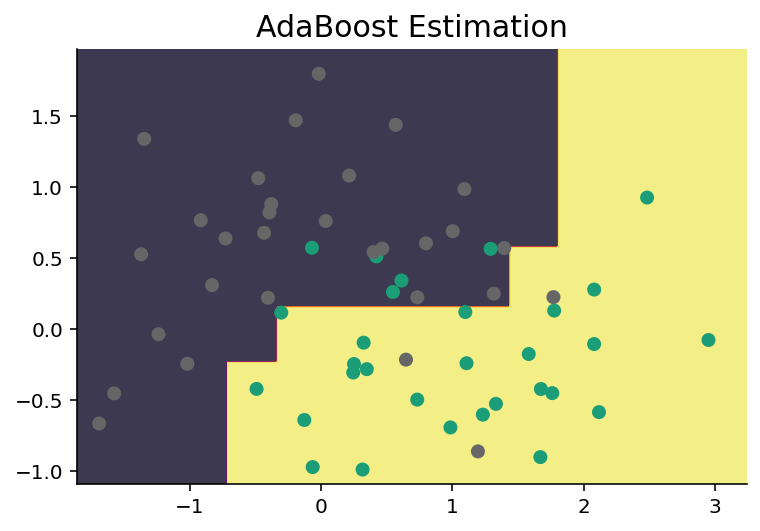

In [13]:
plt.contourf(*Xgrid, yhat_grid, cmap="inferno", alpha=0.8)
plt.scatter(*X.T, c=y, cmap="Dark2_r")
plt.title("AdaBoost Estimation", fontsize=15);

### Graphing the sequential learning scheme

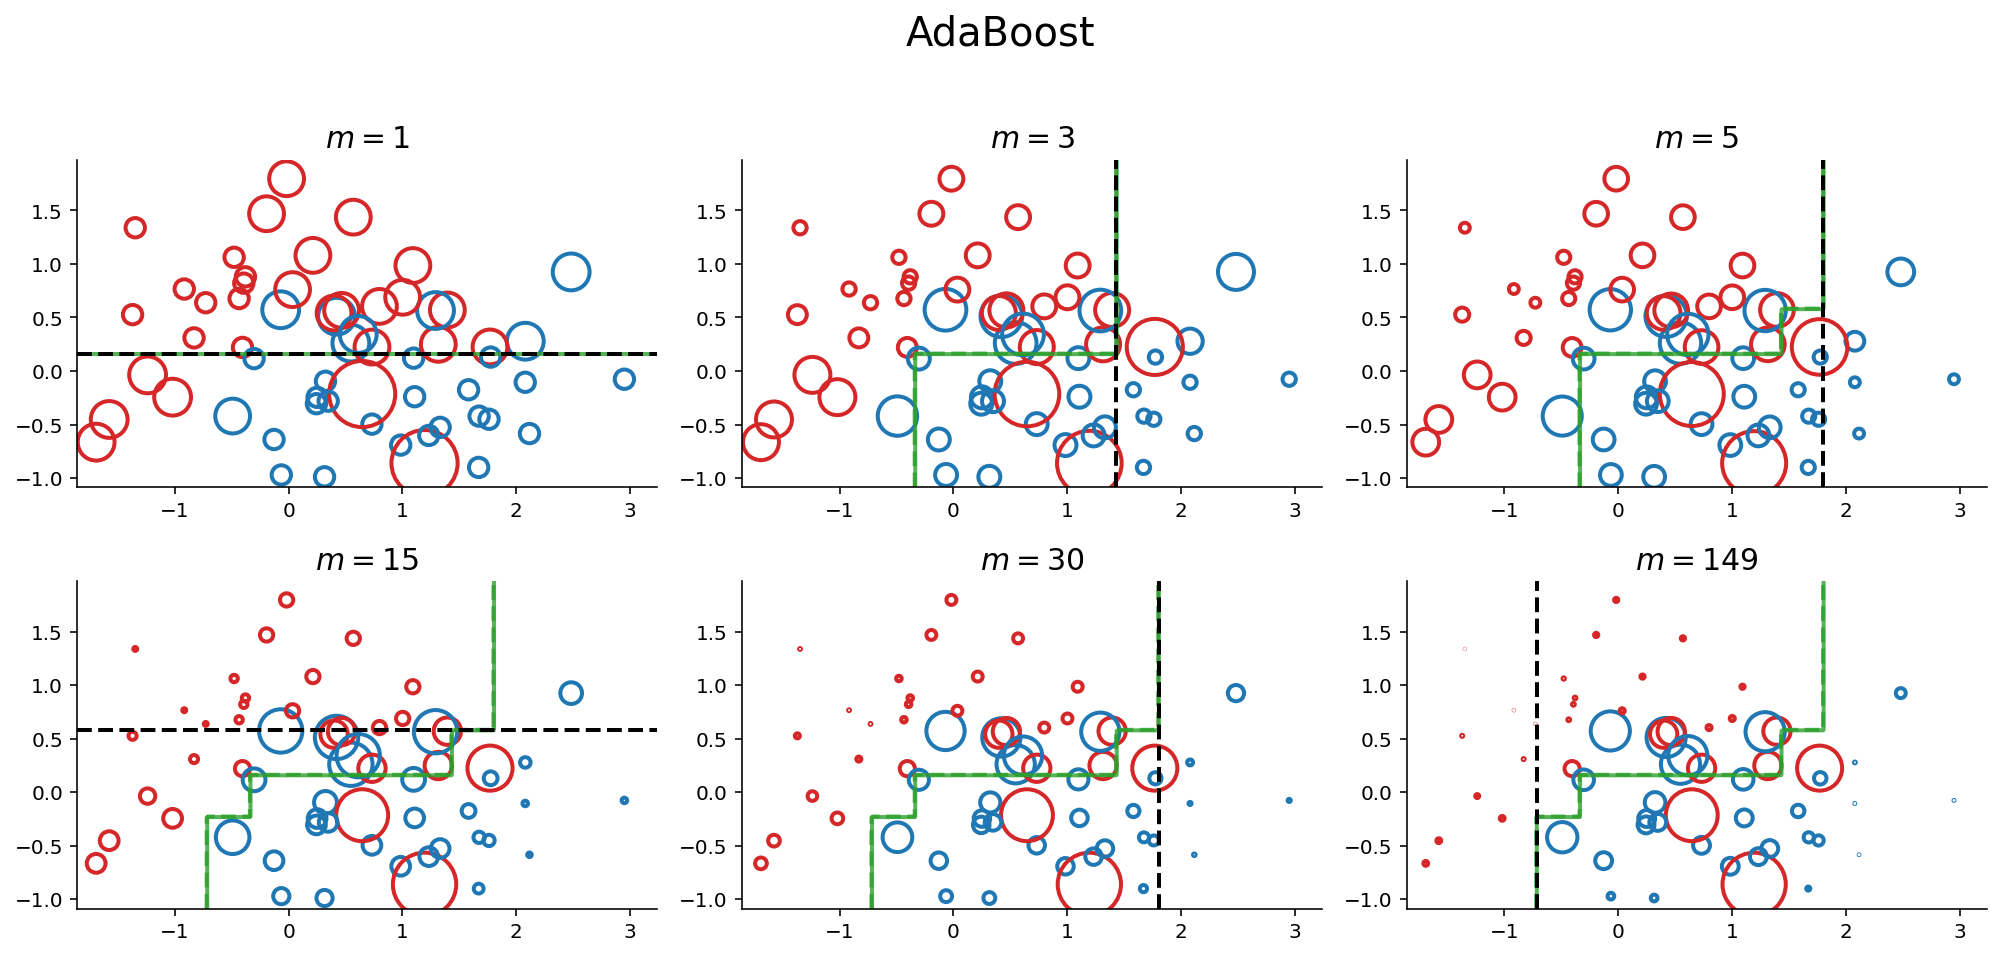

In [14]:
n_base_learners = 149
params = {
    "linestyle": "--",
    "linewidth": 2,
    "color": "black"
}
n_learners = [1, 3, 5, 15, 30, 149]
fig, ax = plt.subplots(2, 3, figsize=(14, 6))
ax = ax.ravel()

for n_base_learners, axi in zip(n_learners, ax):
    yhat_grid = adaboost_predict(Xgrid.T.reshape(-1, 2),
                                 alpha_boost[:n_base_learners],
                                 index_boost[:n_base_learners],
                                 cutoff_boost[:n_base_learners])
    marker_colors = ["tab:red" if yi == -1 else "tab:blue" for yi in y]

    yhat_grid = yhat_grid.reshape(M2, M1).T

    j_cut = index_boost[n_base_learners-1]
    c_cut = cutoff_boost[n_base_learners-1]

    if j_cut == 1:
        axi.axhline(y=c_cut, **params)
    elif j_cut == 0:
        axi.axvline(x=c_cut, **params)

    size_weights = weights_hist[n_base_learners]
    size_weights = 1e3 * size_weights / (size_weights.max() - size_weights.min())

    axi.contour(*Xgrid, yhat_grid, colors="tab:green", alpha=0.8, levels=1, linewidths=2)
    axi.scatter(*X.T, s=size_weights, facecolors="none", edgecolors=marker_colors, linewidth=2)
    axi.set_title(rf"$m={n_base_learners}$", fontsize=15);
    
plt.tight_layout()
plt.suptitle("AdaBoost", y=1.1, fontsize=20);

## AdaBoost error functions

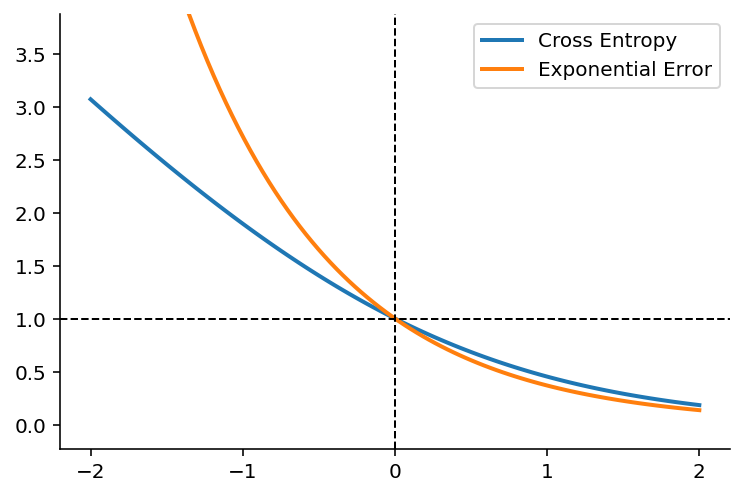

In [15]:
xrange = np.linspace(-2, 2, 100)
x_entropy = np.log(1 + np.exp(-xrange))
exp_error = np.exp(-xrange)

plt.plot(xrange, x_entropy / np.log(2), label="Cross Entropy", linewidth=2)
plt.plot(xrange, exp_error, label="Exponential Error", linewidth=2)
plt.legend()
plt.axhline(y=1, c="black", linewidth=1, linestyle="--")
plt.axvline(x=0, c="black", linewidth=1, linestyle="--")
y_low, y_up = plt.ylim()
plt.ylim(y_low, y_up * 0.5)
plt.xticks([-2, -1, 0, 1, 2]);

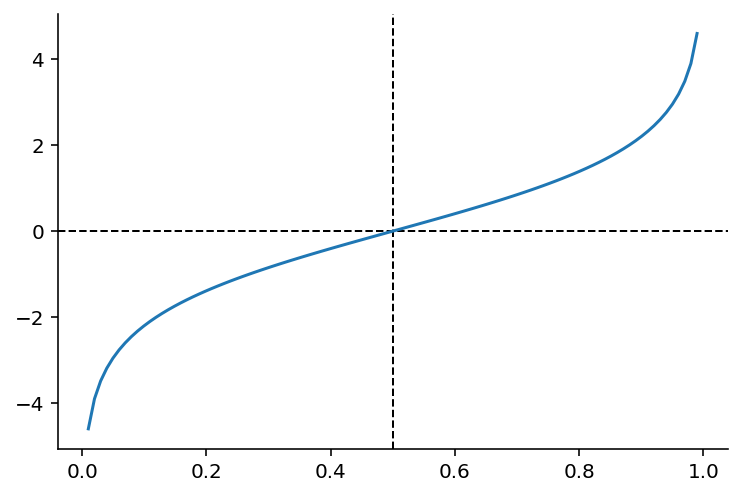

In [16]:
## Log odds
xrange = np.linspace(0.01, 0.99, 100)
log_odds = np.log(xrange / (1 - xrange))
plt.axhline(y=0, c="black", linewidth=1, linestyle="--")
plt.axvline(x=0.5, c="black", linewidth=1, linestyle="--")
plt.plot(xrange, log_odds);

Since AdaBoost is seeking the best approximation to the log-odds ratio, the more *correct* the model is at either side (-1 or 1), the more to the right will be in terms of its exponential error. Hence, we can motivate the use of the sign function to make predictions

**An important note** (Ex. 14.8)  
The exponential error given by AdaBoost does not correspond to any well-defined probability distribution in the sense that the negative-log likelihood that would correspond to the problem depends on terms of $f_M({\bf x})$ that do not appear in the exponential error.